##### XGB-Stepregression   
##20220409sym编写 
### 简介：  
使用逐步回归的方法提取最重要的特征相互作用
### 更新记录：  
V2，20221221sym更新，简化核心步骤

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import gc
c_time = time.strftime("%Y%m%d_%H%M%S", time.localtime())
c_time_m = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())


In [2]:
# 参数
# ======== System Setup ========
Version = 'V2.0sym'
EPOCH = 160
CORE_NUM = 32
# 确保EPOCH*REPEAT_ROUND是CORE_NUM的整数倍
TRAIN_TEST_SPLIT = 0.85
# ======== Fit Data Input ========
S_N = 127
F_N = 54
INPUT_X = 'Features_'+str(S_N)+'_'+str(F_N)+'.csv'
INPUT_Y = 'Values_True_'+str(S_N)+'.csv'
INPUT_TITLE = 'Title_'+str(F_N)+'.csv'
INPUT_SMILES = 'Smiles_'+str(S_N)+'.csv'
RECORD_NAME = 'Record_Stepreg_'+Version+'_'+c_time+'.txt'
#是否设定第一特征
KNOW_inifeat=True
inifeat=[47]
# 记得减一
#F_N-1为全部特征都筛选
Stepfeatnum=5
ifpred=False

In [18]:
F_N

54

In [3]:
import shap
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import model_selection
import joblib
from multiprocessing import Pool

In [4]:
import os
from pathlib import Path

X = np.loadtxt(INPUT_X, delimiter=',')
y = np.loadtxt(INPUT_Y)
title = np.loadtxt(INPUT_TITLE, dtype=str, delimiter=',', comments='!')
smiles = np.loadtxt(INPUT_SMILES, dtype=str, delimiter=',', comments='!')



In [21]:
len(X)

127

In [5]:
DIR = 'Stepreg-XGB_'+Version+'_'+c_time
os.mkdir(DIR)
RECORD_NAME = Path('.', DIR, RECORD_NAME)
f1 = open(RECORD_NAME, 'w')
f1.write('Record of XGB-Stepregression '+Version+'\n\n')
f1.write('Generation time: '+time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())+'\n\n\n')
f1.write('Inputfiles are: '+INPUT_X+'+'+INPUT_Y+'+'+INPUT_TITLE+'+'+INPUT_SMILES+'\n\n\n')
f1.write('EPOCH= '+str(EPOCH)+' CORENUM= '+str(CORE_NUM)+INPUT_X+' splitratio= '+str(round(TRAIN_TEST_SPLIT,3))+'\n\n\n')

61

In [6]:
clf = XGBRegressor(n_estimators=350, learning_rate=0.03, max_depth=8, verbosity=0, booster='gbtree', 
                   reg_alpha=np.exp(-3), reg_lambda=np.exp(-3), gamma=np.exp(-5), 
                   subsample=0.5, objective= 'reg:squarederror', n_jobs=1)
paras = clf.get_params()
mse_list = []
mae_list = []
r2_list = []

In [7]:
def XGB_Fit(X, y, X_train, y_train, X_test, y_test, paras):
    clf_new = XGBRegressor()
    for k, v in paras.items():
        clf_new.set_params(**{k: v})
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    # 拟合模型
    clf_new.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=150, verbose=False)
    # 计算损失
    y_pred = clf_new.predict(X_test)
#     mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
#     shap_values = shap.TreeExplainer(clf_new).shap_values(X)
#     s = np.mean(clf_new.predict(X))-np.mean(y_train)
#     s2 = np.mean(clf_new.predict(X))-np.mean(y)
#     print(np.sum(shap_values), s, s2)
#     # f_i = clf_new.feature_importances_
#      temp = [mse, mae, r2, shap_values, s, s2]
    temp = [mse]
#     print('   MSE: %.5f' % mse, '  MAE: %.5f' % mae, '  R^2: %.5f' % r2)
    del y_pred
    return (temp, 'None')
def flatten(li):
    return sum(([x] if not isinstance(x, list) else flatten(x) for x in li), [])


In [8]:
def poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,X, y, paras):
    r_l = []
    point = round(X.shape[0]*TRAIN_TEST_SPLIT)
    for _ in range(int(EPOCH/CORE_NUM)):
        print('Round', CORE_NUM*(_)+1, 'Begin:')
        pool = Pool(CORE_NUM)
        for __ in range(CORE_NUM):
            permutation = np.random.permutation(y.shape[0])
            train_idx = permutation[:point]
            test_idx = permutation[point:]
            X_train = X[train_idx, :]
            y_train = y[train_idx]
            X_test = X[test_idx, :]
            y_test = y[test_idx]
            r = pool.apply_async(XGB_Fit, args=(X, y, X_train, y_train, X_test, y_test, paras,))
            r_l.append(r)
        pool.close()
        pool.join()
    mse_list=[]
    mae_list=[]
    r2_list=[]
#     shap_m = np.zeros((S_N, F_Ntemp))
    for i in range(len(r_l)):
        r = r_l[i]
        results = r.get()
        temp = results[0]
        mse = temp[0]
#         mae = temp[1]
#         r2 = temp[2]
        mse_list.append(mse)
#         mae_list.append(mae)
#         r2_list.append(r2)

    mse1=np.mean(mse_list)
#     mae1=np.mean(mae_list)
#     r21=np.mean(r2_list)
#     temp = [mse1, mae1, r21]
    temp = [mse1]
    return temp

In [9]:
#在这里mse越小越好
if KNOW_inifeat == False:
    perflist1=[]
    for j in range (F_N):  
        print('Round',j)
        inifeat=title[j]
        inifeatindex=np.where(title==inifeat)[0][0]
        featlist=[]
        featlist.append(inifeatindex)
        Xtemp=X[:,featlist]
        perf=poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,Xtemp, y, paras)
        perflist1.append(perf[0])    
    inifeat=np.where(perflist1==np.min(perflist1))
    print(inifeat)
    print(np.min(perflist1))
    print(perflist1)
    print(np.argsort(perflist1))
    perflistt=np.argsort(perflist1)
    for _ in range(10):
        print(title[perflistt[_]])
#画分布图
    n, bins, patches = plt.hist(perflist1)
    plt.show()
else:
    print('Already given first feature is ',title[inifeat],inifeat)

Already given first feature is  ['Atom1_ESPAllArea_Ang_2_'] [47]


In [10]:
title[inifeat]

array(['Atom1_ESPAllArea_Ang_2_'], dtype='<U39')

In [11]:
inifeatindex=np.where(title==title[inifeat])[0][0]
print('first feature is ',inifeatindex)
featlist=[]
bestfeatlist=[]
mseind=[]
mselist=[]
for i in range(Stepfeatnum):#for i in range(F_N-1):
    perflist=np.linspace(0,0,len(title))
    print('Now we have ', i+1, 'Features.Begin regression!')
    if i ==0:       
        featlist.append(inifeatindex)
        print(featlist)
        Xtemp=X[:,featlist]
        print(Xtemp[0])
        perf=poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,Xtemp, y, paras)
        perflist=perf[0]
        bestfeatlist=featlist
        print('Round 1_'+str(title[bestfeatlist])+'_'+str(perflist)+'\n')
        f1.write('Round 1_'+str(title[bestfeatlist])+'_'+str(perflist)+'\n')
    else:
        for j in range (F_N):     
            featlist=bestfeatlist.copy()
            print('j=',j)
            if j in bestfeatlist:
                print('Already selected feature!')
            else:                   
                featlist.append(j)
                print('featlist=',featlist)
                Xtemp=X[:,featlist]
                print(Xtemp[0])
                perf=poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,Xtemp, y, paras)
                perflist[j]=perf[0]
                print('perflist=',perflist)  
        max2 = np.sort(perflist)[i]
        mseind = np.argsort(perflist)[i]
        print('This feature is',mseind)
        print('best performance is',max2)
        bestfeatlist.append(mseind)
        print('bestfeatlist=',bestfeatlist)
        print(('Round '+str(len(title[bestfeatlist]))+'_'+str(title[bestfeatlist])+'_'+str(round(max2,4))+'\n'))
        f1.write('Round '+str(len(title[bestfeatlist]))+'_'+str(title[bestfeatlist])+'_'+str(round(max2,4))+'\n')
        mselist.append(max2)
        print(mselist)
f1.close()

first feature is  47
Now we have  1 Features.Begin regression!
[47]
[8.69816]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 1_['Atom1_ESPAllArea_Ang_2_']_123.22111808136474

Now we have  2 Features.Begin regression!
j= 0
featlist= [47, 0]
[ 8.69816 52.     ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [90.79531945  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
j= 1
featlist= [4

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [ 90.79531945  96.19493906 107.65410404  99.7654235  129.31019298
  88.81614677  96.10267489  94.17265496 110.95546126  88.0170691
 106.56507235 135.86825123   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.        ]
j= 12
featlist= [47, 12]
[8.69816    0.99362028]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [ 90.79531945  96.19493906 107.65410404  99.7654235  129.31019298
  88.81614677  96.10267489  94.17265496 110.95546126  88.0170691
 106.5

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [ 90.79531945  96.19493906 107.65410404  99.7654235  129.31019298
  88.81614677  96.10267489  94.17265496 110.95546126  88.0170691
 106.56507235 135.86825123 125.58863805  99.94278732 106.33571289
 137.03837928 125.60578411 123.0794036  114.35513582  94.25490983
 100.58667023 126.28893624 107.82671302   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.        ]
j= 23
featlist= [47, 23]
[ 8.69816   13.0370115]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [ 90.79531945  96.19493906 107.65410404  99.7654235  129.31019298
  88.81614677  96.10267489  94.17265496 110.95546126  8

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [ 90.79531945  96.19493906 107.65410404  99.7654235  129.31019298
  88.81614677  96.10267489  94.17265496 110.95546126  88.0170691
 106.56507235 135.86825123 125.58863805  99.94278732 106.33571289
 137.03837928 125.60578411 123.0794036  114.35513582  94.25490983
 100.58667023 126.28893624 107.82671302 121.50079899  95.56010469
  92.84774865  98.99771941 100.01862145 106.4689516  122.23796228
  86.94294749 122.8277692  112.0827568   99.71021944   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.        ]
j= 34
featlist= [47, 34]
[  8.69816 361.52167]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [ 90.79531945  96.19493906 107.65410404  99.7654235  129.31019298
  88.81614677  96.10267489  94.17265496 1

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [ 90.79531945  96.19493906 107.65410404  99.7654235  129.31019298
  88.81614677  96.10267489  94.17265496 110.95546126  88.0170691
 106.56507235 135.86825123 125.58863805  99.94278732 106.33571289
 137.03837928 125.60578411 123.0794036  114.35513582  94.25490983
 100.58667023 126.28893624 107.82671302 121.50079899  95.56010469
  92.84774865  98.99771941 100.01862145 106.4689516  122.23796228
  86.94294749 122.8277692  112.0827568   99.71021944 123.54771365
 135.97952934 119.19144917 117.54219073  99.76741814 107.49064429
 116.86397648 101.7087212  123.97662703 108.0699878    0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.        ]
j= 44
featlist= [47, 44]
[8.69816 1.40223]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [ 90.79531945  96.19493906 107.65410404  99.7654235  129.31019298
  88.81614677  96.10267489  9

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [84.62250789  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
j= 1
featlist= [47, 30, 1]
[ 8.69816 52.      78.     ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [84.62250789 87.34917631  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.   

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [ 84.62250789  87.34917631  88.55456282  83.40123505  85.34592322
  83.03996686 101.09398354  88.85857742  84.93826022  74.92254312
  91.97223351  80.6704188    0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.        ]
j= 12
featlist= [47, 30, 12]
[ 8.69816    52.          0.99362028]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [ 84.62250789  87.34917631  88.55456282  83.40123505  85.34592322
  83.03996686 101.09398354  88.85857742  84.93826022

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [ 84.62250789  87.34917631  88.55456282  83.40123505  85.34592322
  83.03996686 101.09398354  88.85857742  84.93826022  74.92254312
  91.97223351  80.6704188   84.86294122  84.6357093   87.59865151
  75.28741873  95.53022995  85.37299577  86.07846948  86.22146702
  69.21698399  82.80088823  94.60183456   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.        ]
j= 23
featlist= [47, 30, 23]
[ 8.69816   52.        13.0370115]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [ 84.62250789  87.34917631  88.55456282  83.40123505  85.34592322
  83.03996686 101.09398354  88.85857742

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [ 84.62250789  87.34917631  88.55456282  83.40123505  85.34592322
  83.03996686 101.09398354  88.85857742  84.93826022  74.92254312
  91.97223351  80.6704188   84.86294122  84.6357093   87.59865151
  75.28741873  95.53022995  85.37299577  86.07846948  86.22146702
  69.21698399  82.80088823  94.60183456  94.53217513  88.35522189
  84.05330277  95.5013387   81.50177587  80.37951982  79.81422713
   0.          89.25965421  78.89192564  77.69897914   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.        ]
j= 34
featlist= [47, 30, 34]
[  8.69816  52.      361.52167]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [ 84.62250789  87.34917631  88.55456282  83.40123505  85.34592322
  83.03996686 101.09398354

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [ 84.62250789  87.34917631  88.55456282  83.40123505  85.34592322
  83.03996686 101.09398354  88.85857742  84.93826022  74.92254312
  91.97223351  80.6704188   84.86294122  84.6357093   87.59865151
  75.28741873  95.53022995  85.37299577  86.07846948  86.22146702
  69.21698399  82.80088823  94.60183456  94.53217513  88.35522189
  84.05330277  95.5013387   81.50177587  80.37951982  79.81422713
   0.          89.25965421  78.89192564  77.69897914  72.98502135
  94.27407614  83.70284308  87.18944312  80.20917027  91.33856089
  88.27619789  75.50931346  80.74358648  87.80889863   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.        ]
j= 44
featlist= [47, 30, 44]
[ 8.69816 52.       1.40223]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [ 84.62250789  87.34917631  88.55456282  83.40123505  85.34592322
  83.03996686

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [67.90172162  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
j= 1
featlist= [47, 30, 46, 1]
[ 8.69816 52.       0.      78.     ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [67.90172162 69.97533801  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [67.90172162 69.97533801 72.41605108 70.32211332 73.16044307 67.49913346
 75.34608389 71.95975993 68.85897457 64.11487445 77.87925628 72.1450479
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
j= 12
featlist= [47, 30, 46, 12]
[ 8.69816    52.          0.          0.99362028]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [67.90172162 69.97533801 72.41605108 70.32211332 73.16044307 67.49913346
 75.34608389 71.95975993 68.85897457 64.11487445 77.87925628 72.145047

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [67.90172162 69.97533801 72.41605108 70.32211332 73.16044307 67.49913346
 75.34608389 71.95975993 68.85897457 64.11487445 77.87925628 72.1450479
 71.2928569  69.91118668 72.16214611 64.68702357 73.91524748 72.44701134
 69.74293135 67.48935499 65.0624891  70.51025935 71.48026011  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
j= 23
featlist= [47, 30, 46, 23]
[ 8.69816   52.         0.        13.0370115]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [67.90172162 69.97533801 72.41605108 70.32211332 73.16044307 67.49913346
 75.34608389 71.95975993 68.85897457 64.11487445 77.87925628 72.14

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [67.90172162 69.97533801 72.41605108 70.32211332 73.16044307 67.49913346
 75.34608389 71.95975993 68.85897457 64.11487445 77.87925628 72.1450479
 71.2928569  69.91118668 72.16214611 64.68702357 73.91524748 72.44701134
 69.74293135 67.48935499 65.0624891  70.51025935 71.48026011 69.75581423
 70.98588795 73.43754061 70.05029802 74.33449527 70.27642403 68.2924327
  0.         68.83586932 66.56902794 68.39586738 70.31249469  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
j= 35
featlist= [47, 30, 46, 35]
[ 8.69816    52.          0.          0.19626416]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [67.90172162 69.97533801 72.41605108 70.32211332 73.16044307 67.49913346
 75.34608389 71.95975993 68.85897457 64.1148744

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [67.90172162 69.97533801 72.41605108 70.32211332 73.16044307 67.49913346
 75.34608389 71.95975993 68.85897457 64.11487445 77.87925628 72.1450479
 71.2928569  69.91118668 72.16214611 64.68702357 73.91524748 72.44701134
 69.74293135 67.48935499 65.0624891  70.51025935 71.48026011 69.75581423
 70.98588795 73.43754061 70.05029802 74.33449527 70.27642403 68.2924327
  0.         68.83586932 66.56902794 68.39586738 70.31249469 70.91611064
 74.57365882 69.19263181 70.59044798 71.30927133 70.64826164 68.07453926
 70.28152519 69.36485906 65.58183743 68.35479123  0.          0.
  0.          0.          0.          0.          0.          0.        ]
j= 46
Already selected feature!
j= 47
Already selected feature!
j= 48
featlist= [47, 30, 46, 48]
[  8.69816  52.        0.      -53.71854]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [67.90172162 69.97533801 72.41605108 70.32211332

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [66.0160173  71.11975635 69.7083156  70.6859844   0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
j= 4
featlist= [47, 30, 46, 9, 4]
[8.69816e+00 5.20000e+01 0.00000e+00 1.03840e+01 3.81240e-02]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [66.0160173  71.11975635 69.7083156  70.6859844  70.8712425   0.
  0.          0.          0.          0.          0.          0.
  0.          0

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [66.0160173  71.11975635 69.7083156  70.6859844  70.8712425  66.59226444
 69.37239973 68.91629107 68.82756318  0.         67.7771388  67.29568988
 64.10859616 67.06890225 71.13654349 67.88643757  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
j= 16
featlist= [47, 30, 46, 9, 16]
[ 8.69816  52.        0.       10.384     2.331416]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [66.0160173  71.11975635 69.7083156  70.6859844  70.8712425  66.59226444
 69.37239973 68.91629107 68.82756318  0.         67.7771388  67.

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [66.0160173  71.11975635 69.7083156  70.6859844  70.8712425  66.59226444
 69.37239973 68.91629107 68.82756318  0.         67.7771388  67.29568988
 64.10859616 67.06890225 71.13654349 67.88643757 71.34934617 69.08002203
 71.40060626 67.77973257 66.79317423 68.49512218 73.47983699 65.61666041
 71.36328803 66.63496653 66.42070948  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
j= 27
featlist= [47, 30, 46, 9, 27]
[ 8.69816 52.       0.      10.384    2.2007 ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [66.0160173  71.11975635 69.7083156  70.6859844  70.8712425  66.59226444
 69.37239973 68.91629107 68.82756318  0.         67.7

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [66.0160173  71.11975635 69.7083156  70.6859844  70.8712425  66.59226444
 69.37239973 68.91629107 68.82756318  0.         67.7771388  67.29568988
 64.10859616 67.06890225 71.13654349 67.88643757 71.34934617 69.08002203
 71.40060626 67.77973257 66.79317423 68.49512218 73.47983699 65.61666041
 71.36328803 66.63496653 66.42070948 70.28968176 71.17044077 66.36962578
  0.         66.83739192 64.34175455 67.81212656 65.5256627  68.41982103
 72.52213712 70.89541647 69.97243138  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
j= 39
featlist= [47, 30, 46, 9, 39]
[  8.69816  52.        0.       10.384   259.42   ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [66.0160173  71.11975635 69.7083156  70.6859844  70.8712425  66.59226444
 69.37239973 68.91629107 68.8275

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [66.0160173  71.11975635 69.7083156  70.6859844  70.8712425  66.59226444
 69.37239973 68.91629107 68.82756318  0.         67.7771388  67.29568988
 64.10859616 67.06890225 71.13654349 67.88643757 71.34934617 69.08002203
 71.40060626 67.77973257 66.79317423 68.49512218 73.47983699 65.61666041
 71.36328803 66.63496653 66.42070948 70.28968176 71.17044077 66.36962578
  0.         66.83739192 64.34175455 67.81212656 65.5256627  68.41982103
 72.52213712 70.89541647 69.97243138 68.36060705 72.20198387 64.91678524
 69.41849639 64.37364843 67.87359147 69.20820691  0.          0.
 66.47807758 70.46193584 71.1282662   0.          0.          0.        ]
j= 51
featlist= [47, 30, 46, 9, 51]
[ 8.69816  52.        0.       10.384    27.460781]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [66.0160173  71.11975635 69.7083156  70.6859844  70.8712425  66.59226444
 69.37239973 68.91629107

4


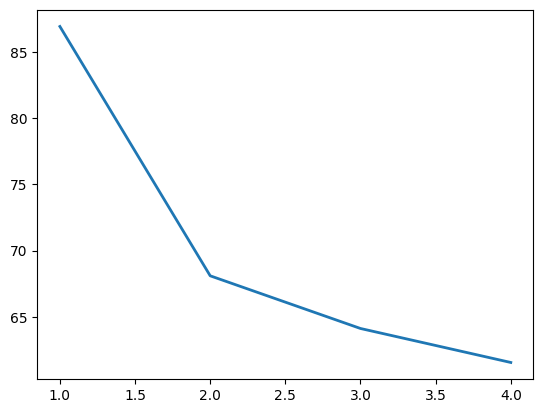

In [12]:
save_name1 = 'XGB-Stepregression_besttitles'+str(len(title[bestfeatlist]))+c_time+'.txt'
save_name2 = Path('.', DIR, save_name1)
with open(save_name2,"w") as f:
    np.savetxt(save_name2,title[bestfeatlist], fmt='%s', delimiter=',', comments='!')
f.close()
import matplotlib.pyplot as plt
import numpy as np
# mselist.insert( 0, perf0)
# make data
x = np.linspace(1, Stepfeatnum-1,Stepfeatnum-1)
print(len(mselist))
y = mselist
# plot
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=2.0)
plt.show()

In [13]:
from sklearn import model_selection
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
def poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,X, y, paras):
    r_l = []
    split_l=[]
    test_idx_m=[]
    point = round(X.shape[0]*TRAIN_TEST_SPLIT)
    for _ in range(int(EPOCH/CORE_NUM)):
        print('Round', CORE_NUM*(_)+1, 'Begin:')
        pool = Pool(CORE_NUM)
        for __ in range(CORE_NUM):
            permutation = np.random.permutation(y.shape[0])
            train_idx = permutation[:point]
            test_idx = permutation[point:]
            X_train = X[train_idx, :]
            y_train = y[train_idx]
            X_test = X[test_idx, :]
            y_test = y[test_idx]
            split_l.append(train_idx)
            test_idx_m.append(test_idx)
            r = pool.apply_async(XGB_Fit, args=(X, y, X_train, y_train, X_test, y_test, paras,))
            r_l.append(r)
        pool.close()
        pool.join()

    mse_list=[]
    mae_list=[]
    r2_list=[]
    results = r.get()
    shap_m = np.zeros((S_N, len(X[0])))
    full_m=np.zeros((len(r_l),X.shape[0]))
    for i in range(len(r_l)):
        r = r_l[i]
        results = r.get()
        temp = results[0]
        mse = temp[0]
        mae = temp[1]
        r2 = temp[2]
        shap_m += temp[3] 
        clf_new=results[1]
        mse_list.append(mse)
        mae_list.append(mae)
        r2_list.append(r2)
        train_idx = split_l[i]
        test_idx = []
        for j in range(X.shape[0]):
            if j not in train_idx:
                test_idx.append(j)
        X_train = X[train_idx, :]
        y_train = y[train_idx]
        X_test = X[test_idx, :]
        y_test = y[test_idx]
        y_full_pred = clf_new.predict(X)
#         print(y_full_pred[0])
        full_m[i]=np.array(y_full_pred)
    mse1=np.mean(mse_list)
    mae1=np.mean(mae_list)
    r21=np.mean(r2_list)
    mse2=np.std(mse_list)
    shap_m2 = shap_m/len(r2_list)
    temp = [mse1, mae1, r21,full_m,test_idx_m,mse2,shap_m2]
    return temp
def XGB_Fit(X, y, X_train, y_train, X_test, y_test, paras):
    clf_new = XGBRegressor()
    for k, v in paras.items():
        clf_new.set_params(**{k: v})
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    # 拟合模型
    clf_new.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=150, verbose=False)
    # 计算损失
    y_pred = clf_new.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    shap_values = shap.TreeExplainer(clf_new).shap_values(X)
    temp0 = [mse, mae, r2, shap_values]
    print('   MSE: %.5f' % mse, '  MAE: %.5f' % mae, '  R^2: %.5f' % r2)
    return (temp0, clf_new)


# Create clf (sklean的API)
shap_m = np.zeros((S_N, len(X[0])))
paras = clf.get_params()
mse_list = []
mae_list = []
r2_list = []
f_i = np.zeros((title.shape[0], 1))
max_r2 = -999.9

In [14]:
title[bestfeatlist]

array(['Atom1_ESPAllArea_Ang_2_', 'SurfaceEffAtomNum',
       'Atom1_LEAEAllAverage', 'MolecularSizeMedium',
       'Atom1_ALIEMinValue'], dtype='<U39')

In [15]:
# bestfeatlist=[8, 84, 89, 68, 109, 2]
# title[bestfeatlist]

X: (127, 54)    y: (127,)
[47]
1
Round 1 Begin:
   MSE: 106.02218   MAE: 8.63020   R^2: 0.00064
   MSE: 200.69411   MAE: 10.96170   R^2: 0.02325
   MSE: 105.12230   MAE: 8.31585   R^2: 0.01827
   MSE: 175.70089   MAE: 9.52321   R^2: 0.10381
   MSE: 96.50741   MAE: 8.62715   R^2: 0.05930
   MSE: 163.16110   MAE: 9.04459   R^2: -0.00554
   MSE: 94.20713   MAE: 7.78800   R^2: 0.35216
   MSE: 87.26078   MAE: 8.82262   R^2: -0.05215
   MSE: 194.50652   MAE: 12.08053   R^2: 0.24462
   MSE: 88.60530   MAE: 7.35302   R^2: 0.32051
   MSE: 214.76210   MAE: 10.81010   R^2: 0.06371
   MSE: 258.96558   MAE: 10.87316   R^2: 0.06561
   MSE: 147.35159   MAE: 9.13044   R^2: 0.16799
   MSE: 155.22601   MAE: 10.04879   R^2: 0.27174
   MSE: 91.84133   MAE: 7.68436   R^2: 0.20343
   MSE: 114.04098   MAE: 8.35856   R^2: 0.17537
   MSE: 179.30394   MAE: 9.41065   R^2: 0.17830
   MSE: 126.12287   MAE: 8.68405   R^2: 0.33533
   MSE: 85.07176   MAE: 7.52395   R^2: 0.32943
   MSE: 157.11449   MAE: 7.77617   R^2:

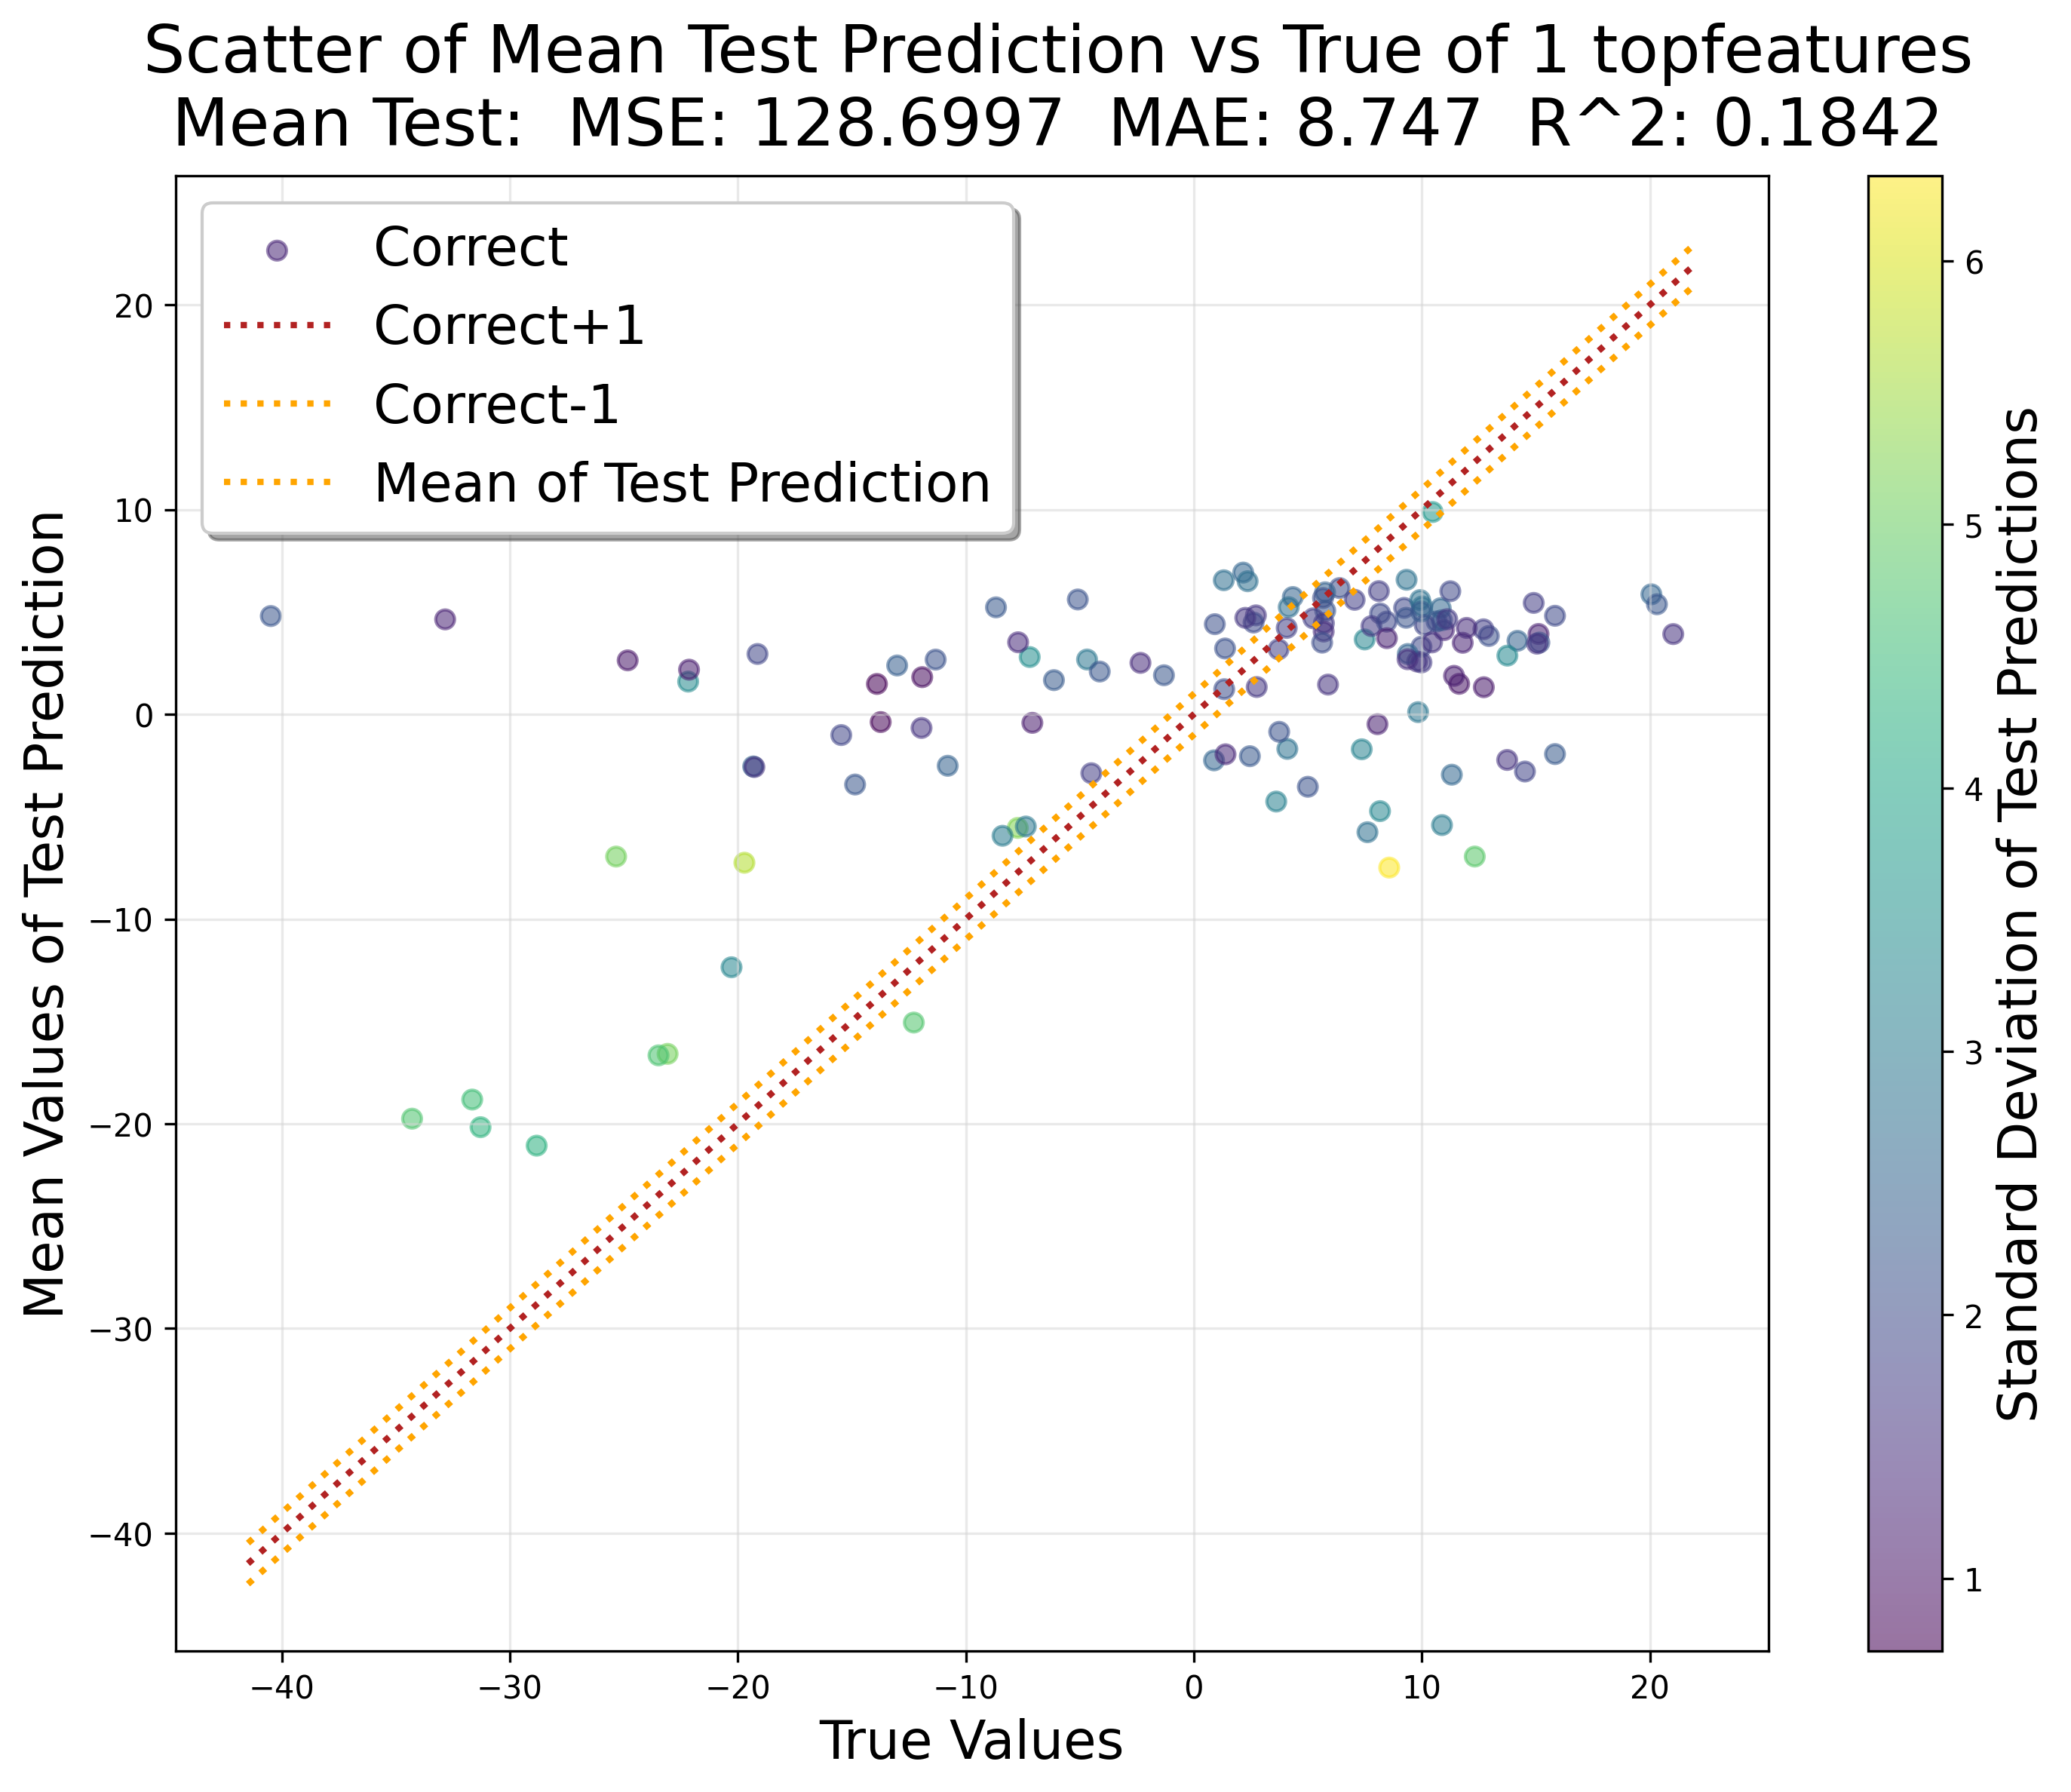

[47, 30]
2
Round 1 Begin:
   MSE: 111.80069   MAE: 6.72596   R^2: 0.14105
   MSE: 67.55433   MAE: 5.59666   R^2: 0.37869
   MSE: 115.03369   MAE: 9.01305   R^2: 0.34371
   MSE: 59.67795   MAE: 6.47603   R^2: 0.51328
   MSE: 59.64199   MAE: 5.97257   R^2: 0.61650
   MSE: 81.38229   MAE: 7.05322   R^2: 0.57194
   MSE: 167.82672   MAE: 9.66840   R^2: 0.16283
   MSE: 67.87120   MAE: 7.00562   R^2: 0.45008
   MSE: 118.01314   MAE: 8.45432   R^2: 0.40003
   MSE: 96.58610   MAE: 6.83465   R^2: 0.50595
   MSE: 65.48108   MAE: 6.49761   R^2: 0.29973
   MSE: 48.04377   MAE: 5.56786   R^2: 0.49563
   MSE: 123.76126   MAE: 8.02161   R^2: 0.47008
   MSE: 63.28036   MAE: 5.93653   R^2: 0.54172
   MSE: 74.79290   MAE: 6.47442   R^2: 0.51588
   MSE: 96.24031   MAE: 7.28677   R^2: 0.43889
   MSE: 62.43879   MAE: 6.63295   R^2: 0.67672
   MSE: 67.50154   MAE: 5.48761   R^2: 0.49102
   MSE: 93.88150   MAE: 6.98092   R^2: 0.48260
   MSE: 86.56253   MAE: 6.36125   R^2: 0.55246
   MSE: 69.23425   MAE: 6.607

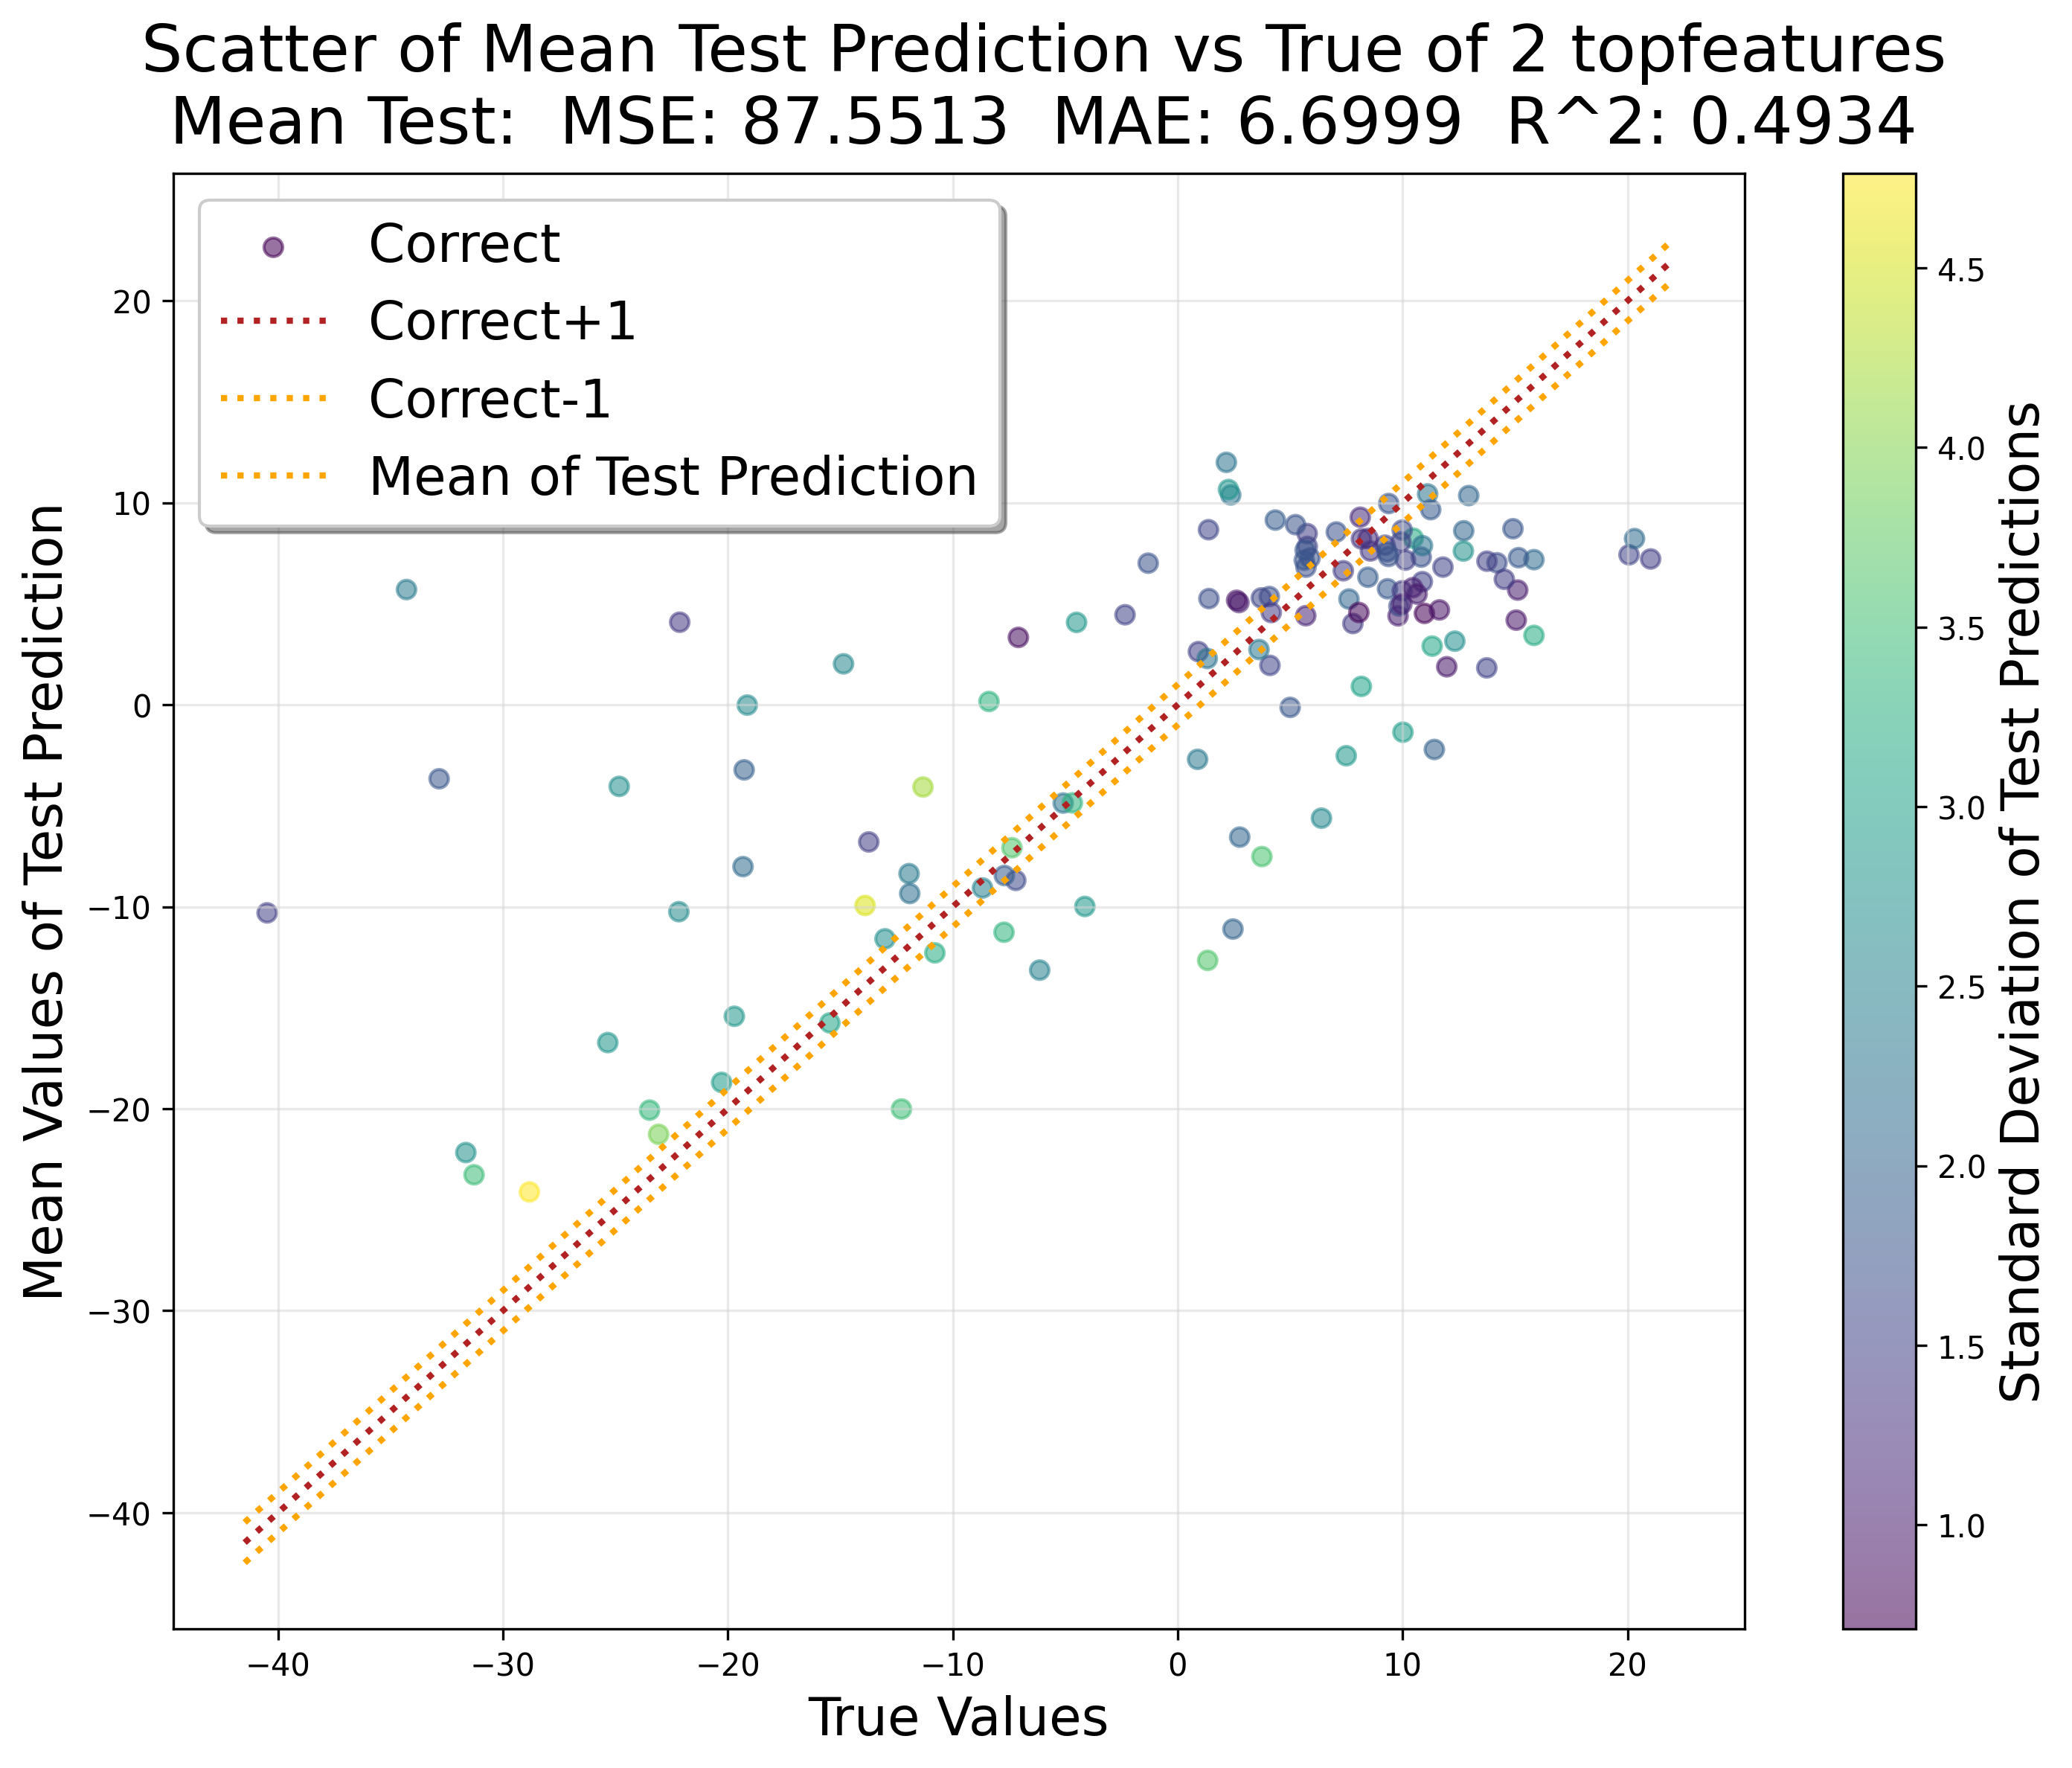

[47, 30, 46]
3
Round 1 Begin:
   MSE: 55.68596   MAE: 6.51978   R^2: 0.59685
   MSE: 78.92741   MAE: 6.92751   R^2: 0.43876
   MSE: 49.13527   MAE: 5.43519   R^2: 0.39418
   MSE: 41.87744   MAE: 5.22875   R^2: 0.56644
   MSE: 64.93976   MAE: 6.64573   R^2: 0.51736
   MSE: 68.62327   MAE: 6.97332   R^2: 0.48570
   MSE: 50.46284   MAE: 5.93204   R^2: 0.69361
   MSE: 43.18515   MAE: 5.25523   R^2: 0.73696
   MSE: 131.76504   MAE: 8.57666   R^2: 0.27063
   MSE: 60.63057   MAE: 5.71522   R^2: 0.59644
   MSE: 117.81584   MAE: 7.68136   R^2: 0.37346
   MSE: 53.92966   MAE: 5.83786   R^2: 0.48898
   MSE: 54.47476   MAE: 5.71607   R^2: 0.52721
   MSE: 58.18669   MAE: 6.24970   R^2: 0.56163
   MSE: 44.93209   MAE: 5.30217   R^2: 0.50139
   MSE: 53.47890   MAE: 5.59889   R^2: 0.58969
   MSE: 84.90199   MAE: 6.22463   R^2: 0.59931
   MSE: 102.28720   MAE: 8.11283   R^2: 0.47327
   MSE: 91.02017   MAE: 6.75991   R^2: 0.51619
   MSE: 49.69578   MAE: 5.93950   R^2: 0.75592
   MSE: 51.57702   MAE: 5.5

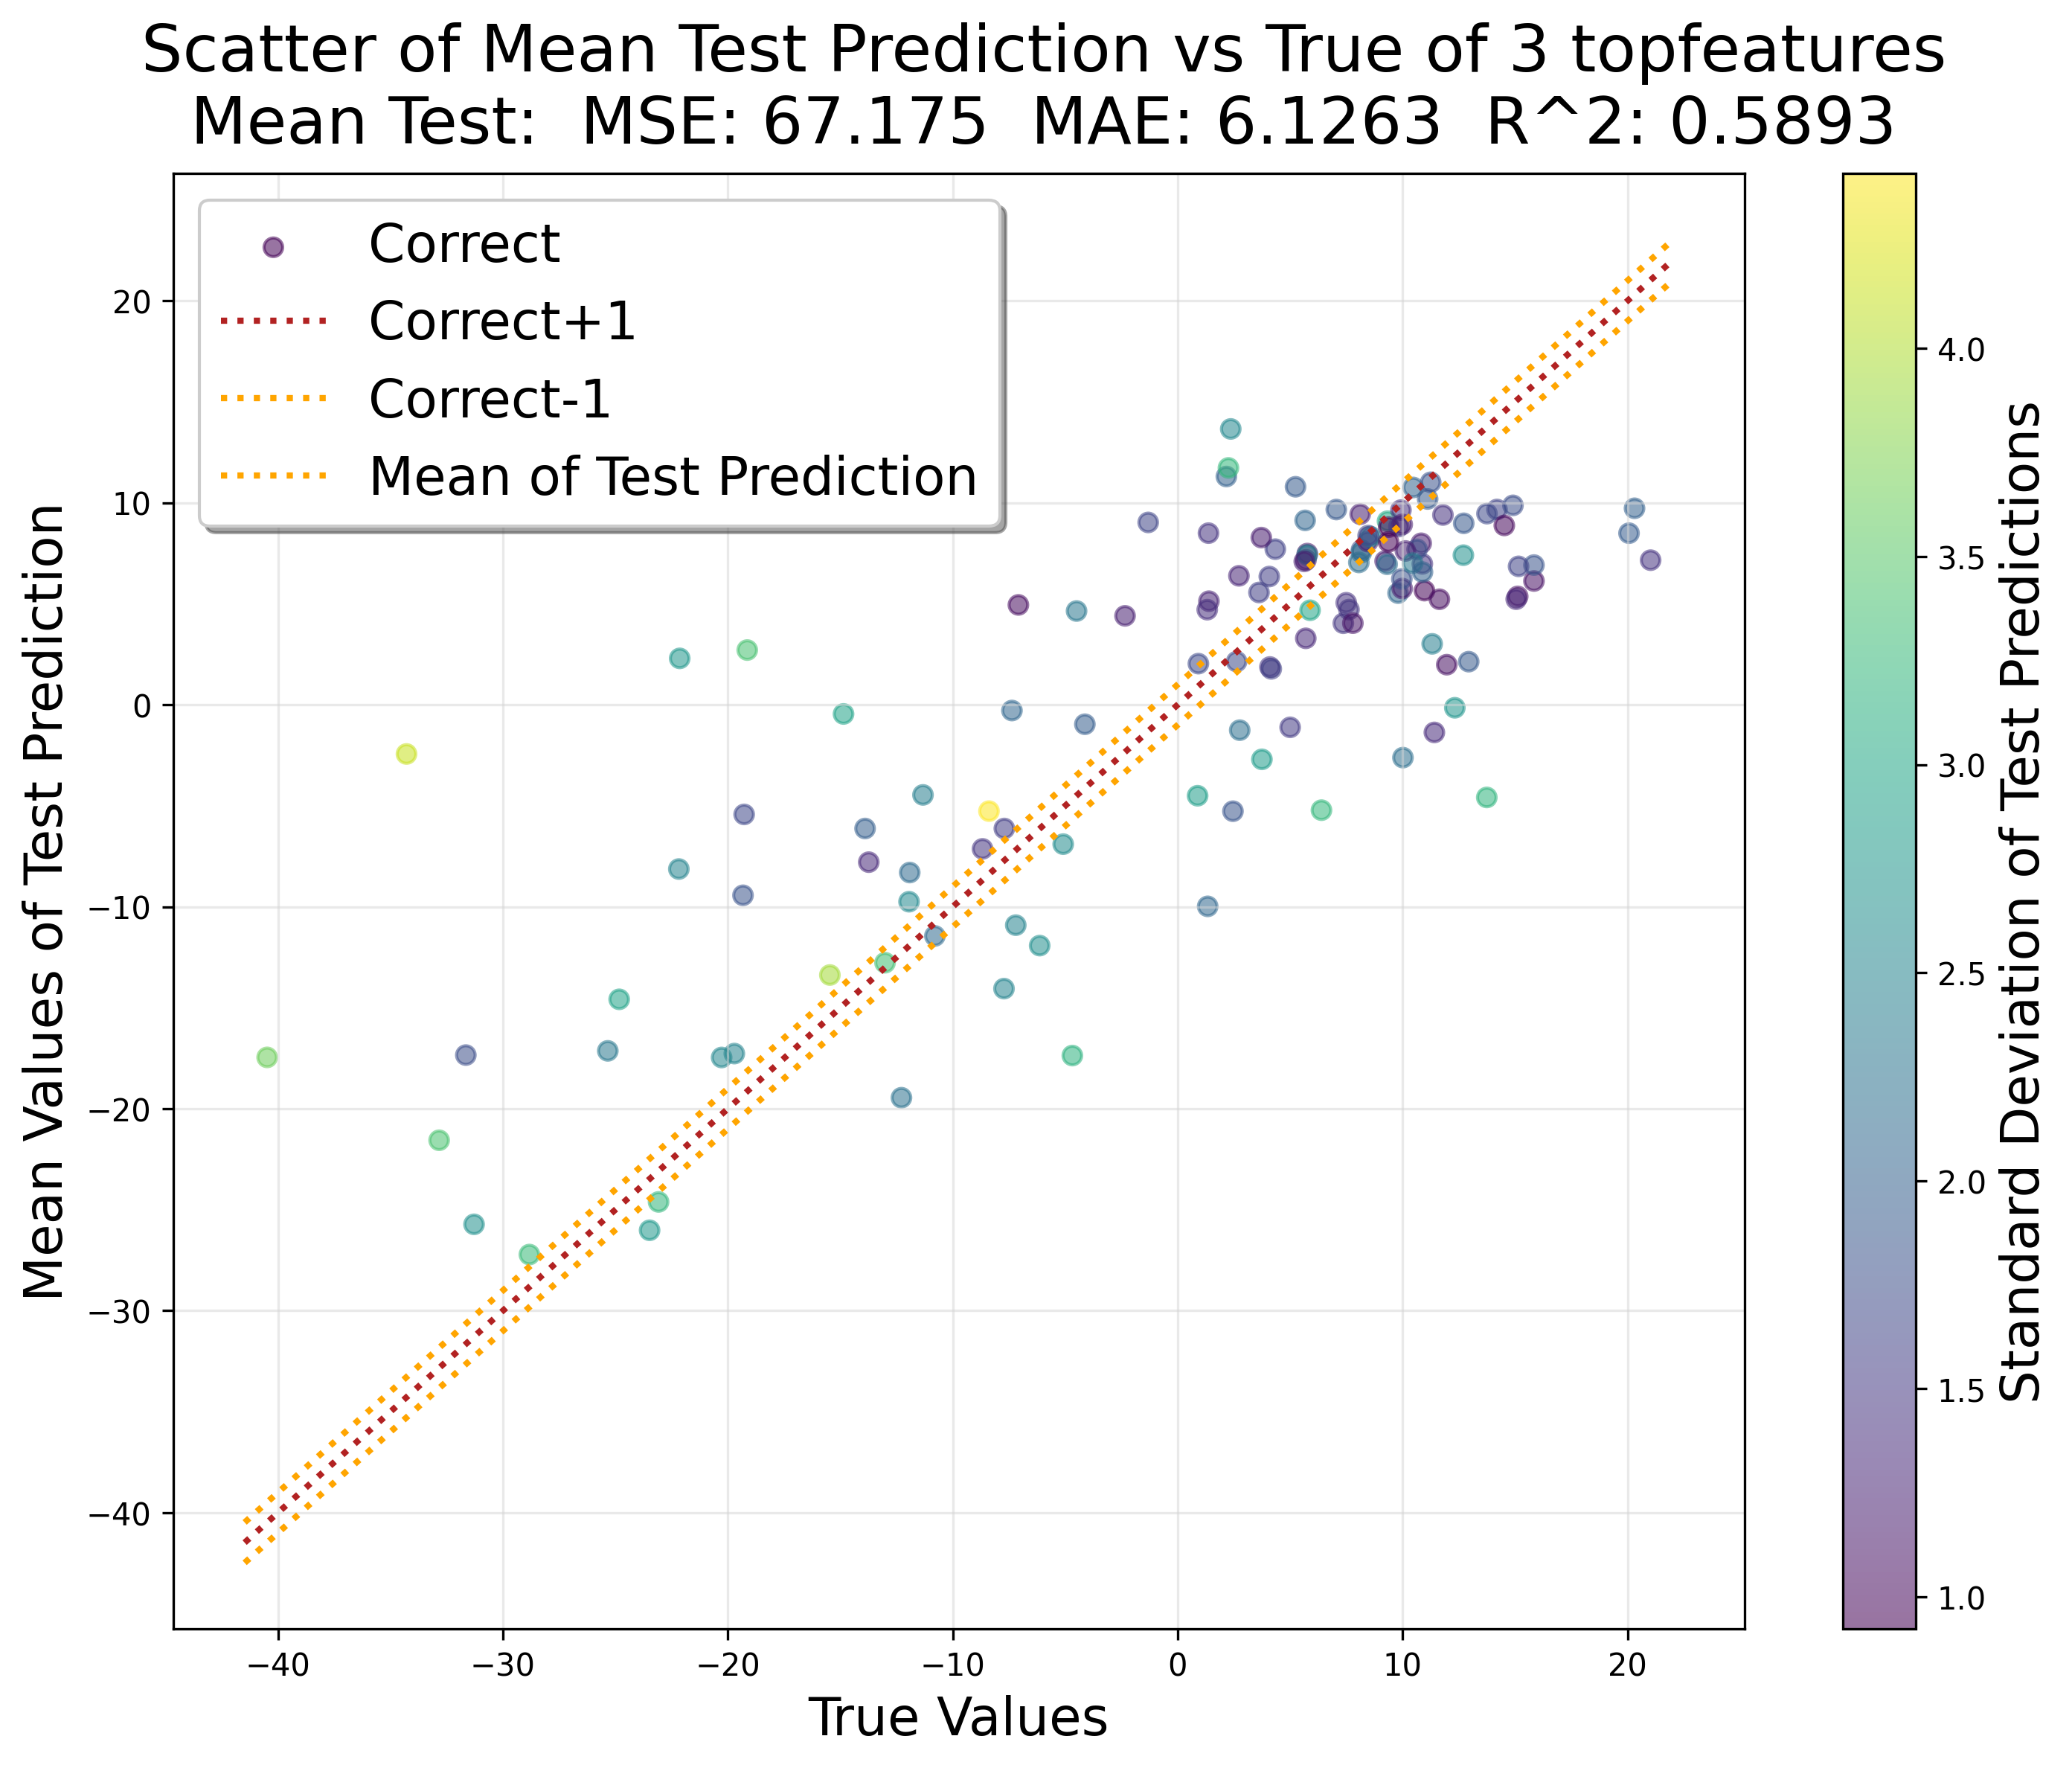

[47, 30, 46, 9]
4
Round 1 Begin:
   MSE: 43.22052   MAE: 5.43371   R^2: 0.18920
   MSE: 62.70728   MAE: 6.54530   R^2: 0.26034
   MSE: 42.33790   MAE: 4.74735   R^2: 0.56089
   MSE: 60.86421   MAE: 6.72350   R^2: 0.44046
   MSE: 113.51272   MAE: 6.81290   R^2: 0.22431
   MSE: 74.42537   MAE: 6.68999   R^2: 0.34197
   MSE: 72.80233   MAE: 6.17171   R^2: 0.49476
   MSE: 37.30707   MAE: 5.02765   R^2: 0.74092
   MSE: 55.69200   MAE: 5.49918   R^2: 0.65147
   MSE: 46.29776   MAE: 5.72233   R^2: 0.68262
   MSE: 44.35787   MAE: 5.44065   R^2: 0.63643
   MSE: 50.98929   MAE: 5.69716   R^2: 0.51939
   MSE: 51.55306   MAE: 5.42647   R^2: 0.68650
   MSE: 120.65011   MAE: 7.11547   R^2: 0.37506
   MSE: 45.25199   MAE: 4.96210   R^2: 0.71868
   MSE: 12.77760   MAE: 2.60665   R^2: 0.87748
   MSE: 122.56435   MAE: 7.32372   R^2: 0.33356
   MSE: 47.47017   MAE: 5.30117   R^2: 0.55162
   MSE: 63.17668   MAE: 6.23652   R^2: 0.57828
   MSE: 32.70164   MAE: 4.22749   R^2: 0.67986
   MSE: 85.71634   MAE: 

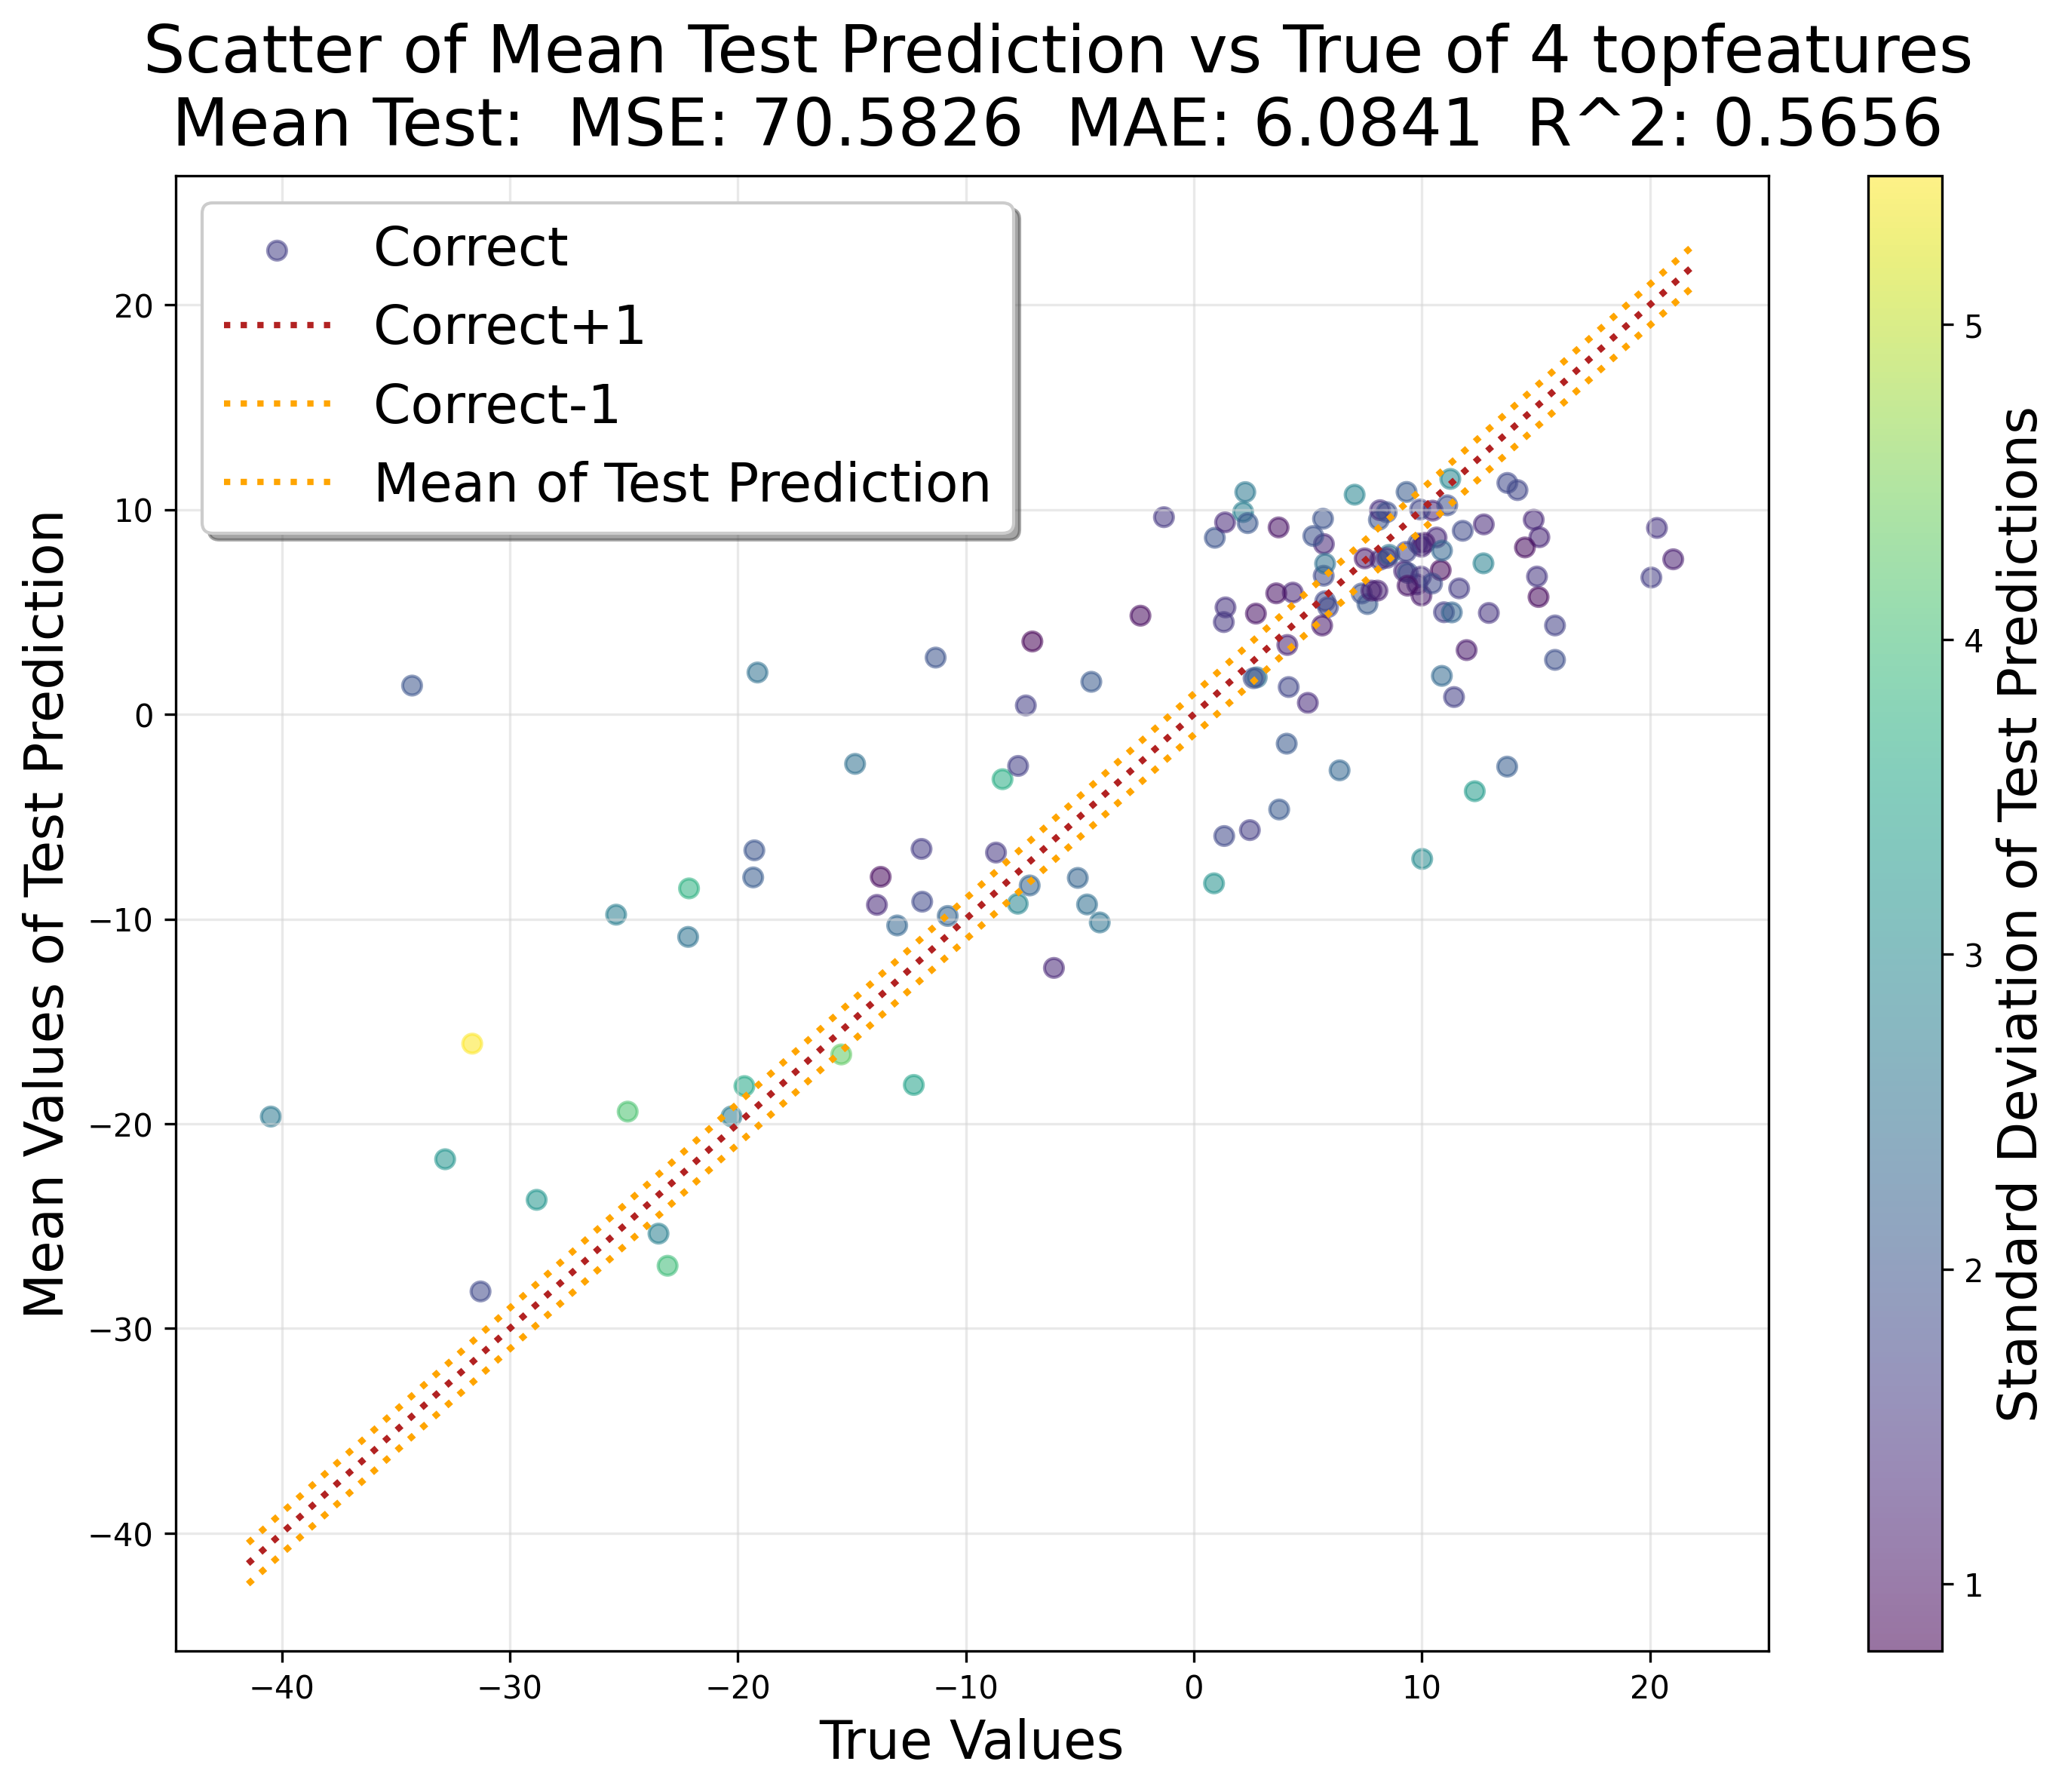

[47, 30, 46, 9, 52]
5
Round 1 Begin:
   MSE: 59.96121   MAE: 5.48916   R^2: 0.60564
   MSE: 74.09699   MAE: 6.41421   R^2: 0.44739
   MSE: 53.04720   MAE: 5.43372   R^2: 0.62160
   MSE: 97.26341   MAE: 6.44180   R^2: 0.37831
   MSE: 74.40202   MAE: 7.60848   R^2: 0.35280
   MSE: 46.84458   MAE: 6.08512   R^2: 0.63885
   MSE: 106.02697   MAE: 6.94258   R^2: 0.20331
   MSE: 112.88033   MAE: 6.80546   R^2: 0.27499
   MSE: 58.74850   MAE: 5.55196   R^2: 0.62540
   MSE: 45.31812   MAE: 5.13713   R^2: 0.68664
   MSE: 37.63437   MAE: 4.29007   R^2: 0.73369
   MSE: 44.14582   MAE: 5.16261   R^2: 0.69114
   MSE: 73.45384   MAE: 6.46211   R^2: 0.71614
   MSE: 44.23010   MAE: 4.81687   R^2: 0.73753
   MSE: 58.71781   MAE: 5.54452   R^2: 0.51800
   MSE: 62.86318   MAE: 5.98227   R^2: 0.69374
   MSE: 30.84994   MAE: 4.36610   R^2: 0.75834
   MSE: 26.91081   MAE: 4.19581   R^2: 0.85209
   MSE: 42.70610   MAE: 4.77649   R^2: 0.85623
   MSE: 49.45434   MAE: 5.72246   R^2: 0.72672
   MSE: 49.75304   MA

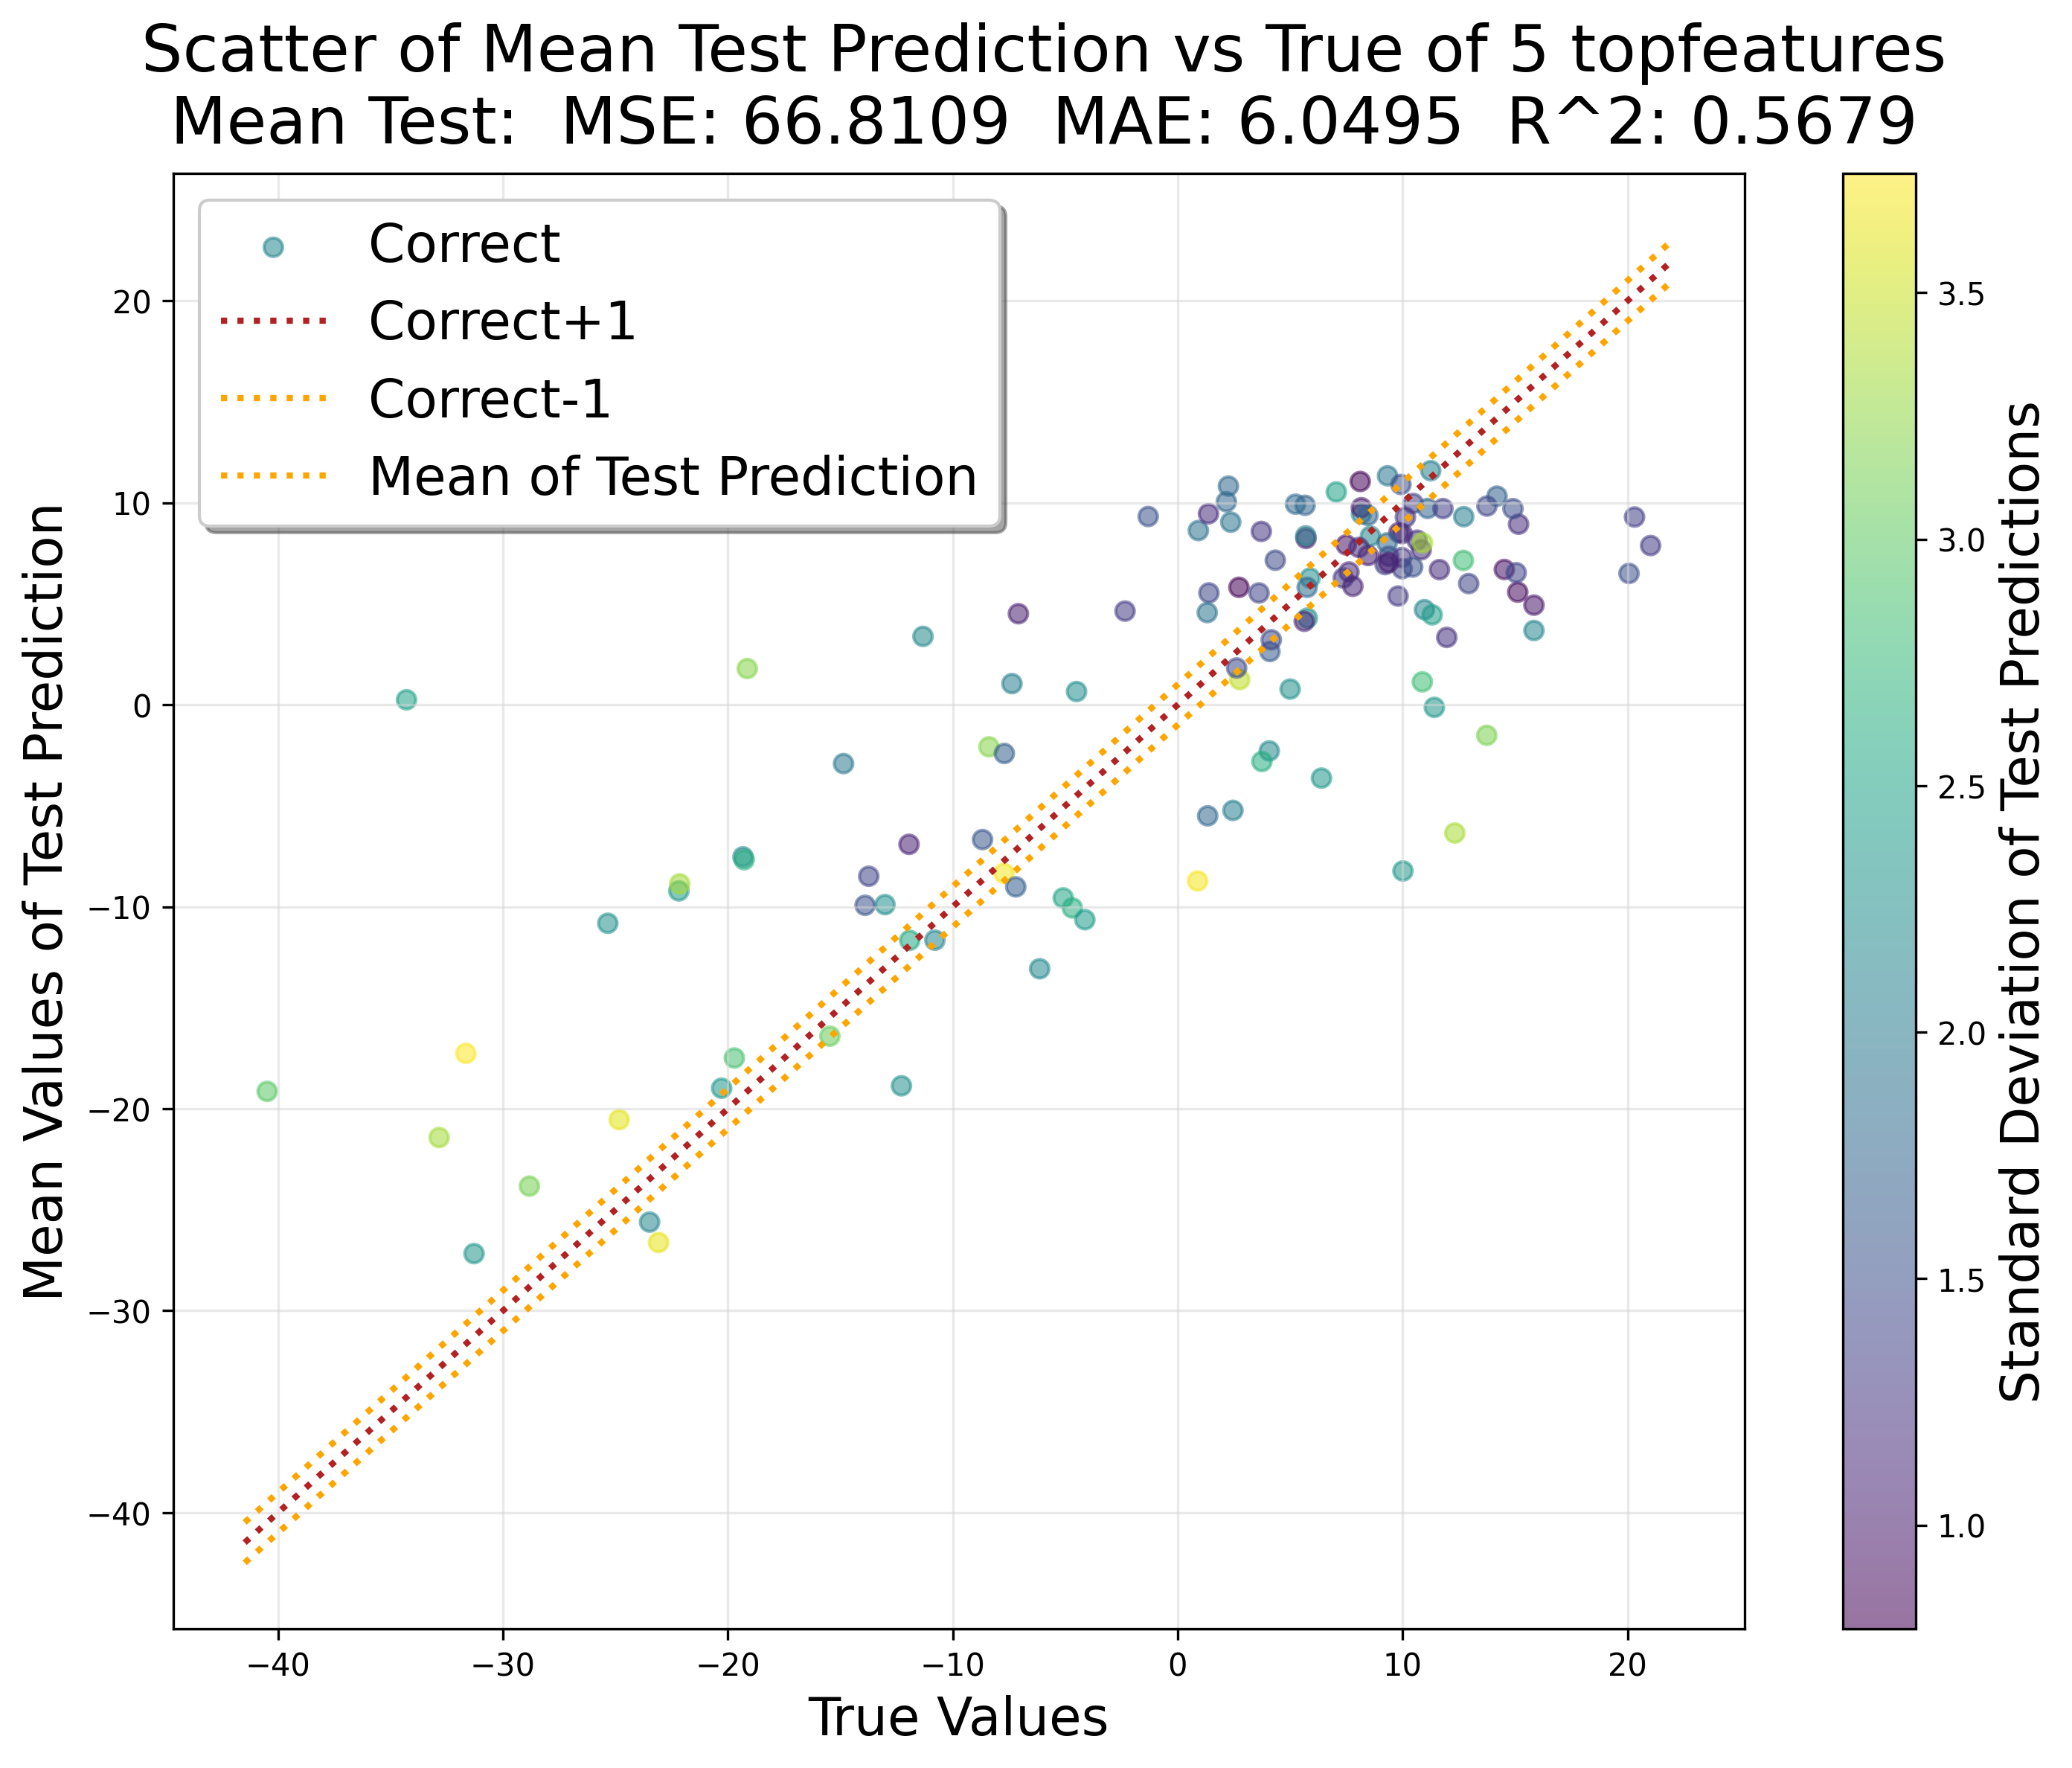

In [22]:
X = np.loadtxt(INPUT_X, delimiter=',')
y = np.loadtxt(INPUT_Y)
print('X:', X.shape, '   y:', y.shape)
besttitle =title[bestfeatlist]
thistitleindex=[]
titlelist=[]
mselist=[]
Xtemp=[]
S_N =127
for jj in range(len(besttitle)):#len(title)-1
    thistitleindex=np.where(title==besttitle[jj])
    titlelist.append(thistitleindex[0][0])
    print(titlelist)
    Xtemp=X[:,titlelist]
#     print(Xtemp)
    print(len(Xtemp[0]))
    
    
    perf=poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,Xtemp, y, paras)
    full_m=perf[3]
    full_m = np.array(full_m)
    test_idx_m = perf[4]
    test_idx_m = np.array(test_idx_m)
    save_name = 'XGBoost_02a_Test_Index_'+str(len(Xtemp[0]))+'_'+c_time+'.csv'
    save_name = Path('.', DIR, save_name)
    np.savetxt(save_name, test_idx_m, fmt='%d', delimiter=',')
    shap_m=perf[6]
    save_name = 'SHAP_Matrix_'+str(len(titlelist))+'_'+c_time+'.csv'
    save_name = Path('.', DIR, save_name)
    np.savetxt(save_name, shap_m, fmt='%s', delimiter=',')
    save_nameX = 'Feature_Matrix_'+str(len(titlelist))+'_'+c_time+'.csv'
    save_nameX = Path('.', DIR, save_nameX)
    np.savetxt(save_nameX, Xtemp, fmt='%s', delimiter=',')
    test_data_m = []
    for i in range(X.shape[0]):
        test_data_m.append([])
    for i in range(test_idx_m.shape[0]):
        for j in range(test_idx_m.shape[1]):
            test_data_m[test_idx_m[i, j]].append(full_m[i, test_idx_m[i, j]])
    test_upper_l = []
    test_lower_l = []
    test_mean_l = []
    test_median_l = []
    test_std_l = []
    for i in range(X.shape[0]):
        test_upper_l.append(max(test_data_m[i]))
        test_lower_l.append(min(test_data_m[i]))
        test_mean_l.append(np.mean(test_data_m[i]))
        test_median_l.append(np.median(test_data_m[i]))
        test_std_l.append(np.std(test_data_m[i]))
        
    true_y = y.flatten().tolist()
    fig = plt.figure(figsize=(10, 8), dpi=300)
    ax = fig.add_axes([0.11, 0.08, 0.88, 0.815])
    sc = ax.scatter(true_y, test_mean_l, alpha=0.55, c=test_std_l, cmap='viridis', marker='o')
    left_limit = min(min(true_y)-1, min(test_mean_l)-1)
    right_limit = max(max(true_y)+1, max(test_mean_l)+1)
    ax.plot([left_limit, right_limit], [left_limit, right_limit], color='#B22222', linestyle=':', linewidth = '2')
    ax.plot([left_limit, right_limit], [left_limit+1, right_limit+1], color='#FFA500', linestyle=':', linewidth = '2')
    ax.plot([left_limit, right_limit], [left_limit-1, right_limit-1], color='#FFA500', linestyle=':', linewidth = '2')
    ax.legend(['Correct', 'Correct+1', 'Correct-1', 'Mean of Test Prediction'], loc='upper left', fontsize=17, shadow=True)
    ax.set_xlabel('True Values', fontsize=17)
    ax.set_ylabel('Mean Values of Test Prediction', fontsize=17)
    plt.suptitle('Scatter of Mean Test Prediction vs True of '+str(len(Xtemp[0]))+' topfeatures\n'+
                 'Mean Test:  MSE: '+str(round(perf[0], 4))+
                 '  MAE: '+str(round(perf[1], 4))+
                 '  R^2: '+str(round(perf[2], 4)), fontsize=21)
    cb = plt.colorbar(sc)
    cb.set_label('Standard Deviation of Test Predictions', fontsize=17)
    plt.grid(which='major', color='#D5D5D5', alpha=0.5)
    save_name = 'XGBoost_02b_Mean_Test_Prediction_Distribution_'+str(len(Xtemp[0]))+'_'+c_time+'.png'
    save_name = Path('.', DIR, save_name)
    plt.savefig(save_name)
    plt.show()
    mselist.append(round(perf[0],3))
    xgbscatterdata= np.column_stack((true_y, test_mean_l, test_std_l))
    save_name1 = 'XGBoost_02c_Mean_Test_Prediction_Distribution_'+str(len(Xtemp[0]))+'_topfeatures'+'_MSE'+str(round(perf[0],3))+'_MSEstd'+str(round(perf[5],3))+'_MAE'+str(round(perf[1],3))+'_R^sq'+str(round(perf[2],3))+besttitle[jj]+'.txt'
    save_name2 = Path('.', DIR, save_name1)
    with open(save_name2,"w") as f:
        np.savetxt(save_name2,xgbscatterdata, fmt='%s', delimiter=',', comments='!')
    f.close()

[128.7, 87.551, 67.175, 70.583, 66.811]
4
['Atom1_ESPAllArea_Ang_2_' 'SurfaceEffAtomNum' 'Atom1_LEAEAllAverage'
 'MolecularSizeMedium' 'Atom1_ALIEMinValue']
[47]
[47, 30]
[47, 30, 46]
[47, 30, 46, 9]
[47, 30, 46, 9, 52]


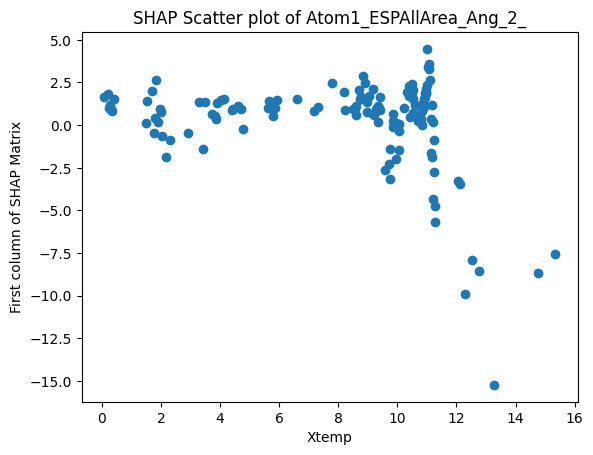

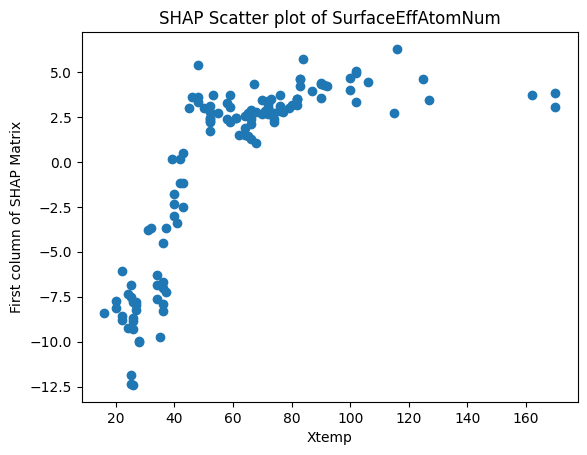

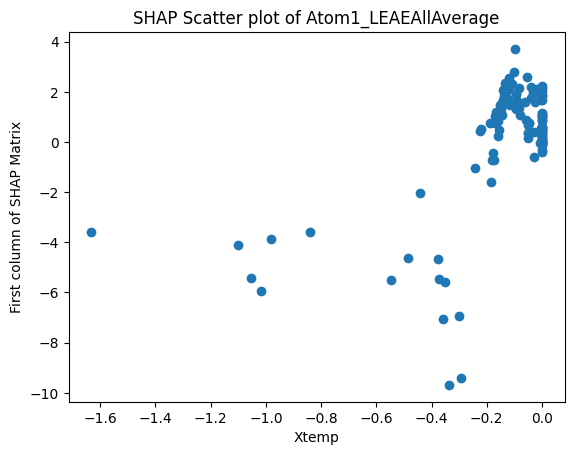

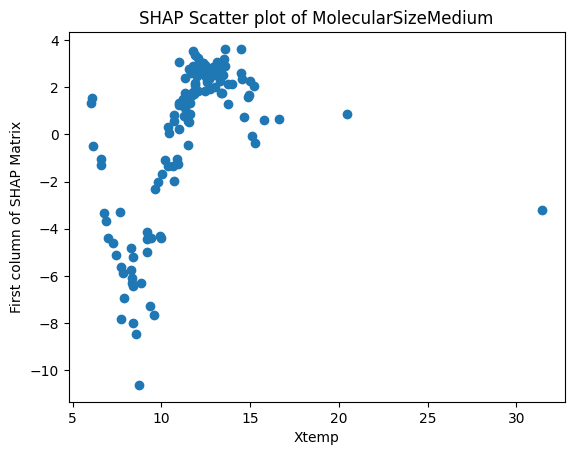

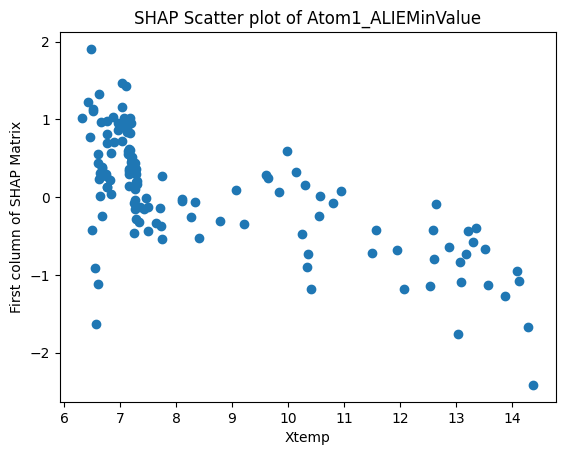

In [23]:
print(mselist)
print(mselist.index(min(mselist)))
print(title[bestfeatlist])
titlelist=[]
Xtemp=[]
for jj in range(len(bestfeatlist)):#len(title)-1
    thistitleindex=np.where(title==besttitle[jj])
    titlelist.append(thistitleindex[0][0])
    print(titlelist)
    Xtemp=X[:,titlelist]
# Create a scatter plot
for jj in range(len(bestfeatlist)):#len(title)-1
    plt.scatter(Xtemp[:,jj], shap_m[:, jj])
    plt.xlabel('Xtemp')
    plt.ylabel('First column of SHAP Matrix')
    plt.title('SHAP Scatter plot of '+title[titlelist[jj]])
    save_name = 'XGBoost_02b_Mean_Test_Prediction_Distribution_'+str(title[titlelist[jj]])+'_'+c_time+'.png'
    save_name = Path('.', DIR, save_name)
    plt.savefig(save_name)
    plt.show()

In [ ]:
S_N=12
INPUT_Xtest = 'Features_'+str(S_N)+'_'+str(F_N)+'.csv'
INPUT_Ytest = 'Values_True_'+str(S_N)+'.csv'
Xrealtest = np.loadtxt(INPUT_Xtest, delimiter=',')
yrealtest = np.loadtxt(INPUT_Ytest)

In [ ]:
if ifpred==True:
    point = round(X.shape[0]*TRAIN_TEST_SPLIT)
    featnum=mselist.index(min(mselist))
    permutation = np.random.permutation(y.shape[0])
    train_idx = permutation[:point]
    test_idx = permutation[point:]
    X_train = X[train_idx, :]
    y_train = y[train_idx]
    X_test = X[test_idx, :]
    y_test = y[test_idx]
    
    # 初始化XGBRegressor对象

    
    # 设置模型的超参数
    for k, v in paras.items():
        clf.set_params(**{k: v})
    
    # 拟合模型，使用验证集进行早停
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=150, verbose=False)
    
    # 计算在测试集上的预测值
    y_pred = clf.predict(Xrealtest)
    print(y_pred)
    mae = mean_absolute_error(yrealtest, y_pred)
    print(mae)
    titlelist=[]
    Xtemp=[]
    Xrealtesttemp=[]
    for jj in range(featnum):#len(title)-1
        thistitleindex=np.where(title==besttitle[jj])
        titlelist.append(thistitleindex[0][0])
        print(titlelist)
        Xtemp=X[:,titlelist]
        Xrealtesttemp=Xrealtest[:,titlelist]
    clf.fit(Xtemp, y)
    # 计算损失
    y_pred2 = clf.predict(Xrealtesttemp)
    print(y_pred2)
    mae = mean_absolute_error(yrealtest, y_pred2)
    print(mae)

In [ ]:
[y_pred,y_pred2]

In [ ]:
save_name1 = 'XGBpred'+'.txt'
save_name2 = Path('.', DIR, save_name1)
with open(save_name2,"w") as f:
    np.savetxt(save_name2,[y_pred,y_pred2], fmt='%s', delimiter=',', comments='!')
f.close()